🌱 Global random seed set to 42
Epoch 1/800


/g/g90/dhakal1/All/newenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-12 13:27:22.486939: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-12 13:27:22.615434: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preser

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4246 - mape: 88.4159 - val_loss: 0.3696 - val_mape: 114.4883 - learning_rate: 5.0000e-04
Epoch 2/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3796 - mape: 77.0702 - val_loss: 0.3605 - val_mape: 112.7597 - learning_rate: 5.0000e-04
Epoch 3/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3978 - mape: 81.7679 - val_loss: 0.3523 - val_mape: 112.8493 - learning_rate: 5.0000e-04
Epoch 4/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3464 - mape: 74.8643 - val_loss: 0.3413 - val_mape: 110.5201 - learning_rate: 5.0000e-04
Epoch 5/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3709 - mape: 72.3085 - val_loss: 0.3305 - val_mape: 106.7115 - learning_rate: 5.0000e-04
Epoch 6/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3658 - mape: 79.0246 - val_loss: 0.3212 - val_mape: 103.5321 - learning_rate: 5.0000e-04
Epoch 7/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3518 - mape: 71.5159 - val_loss: 0.3128 - val_mape: 100.

2026-01-12 13:27:30.492672: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


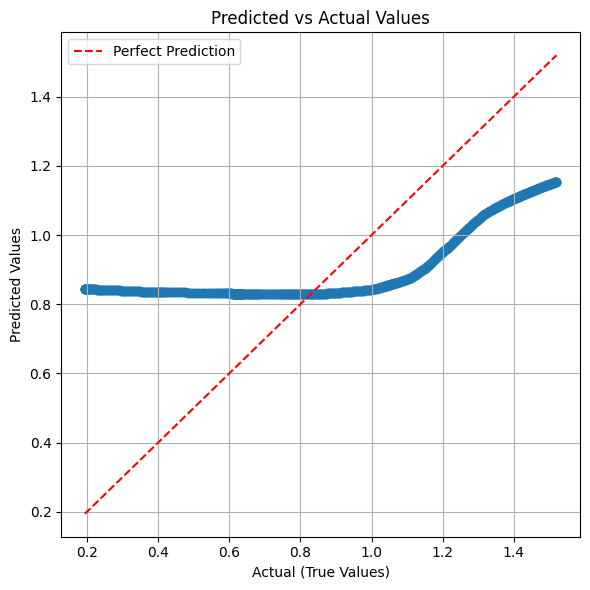

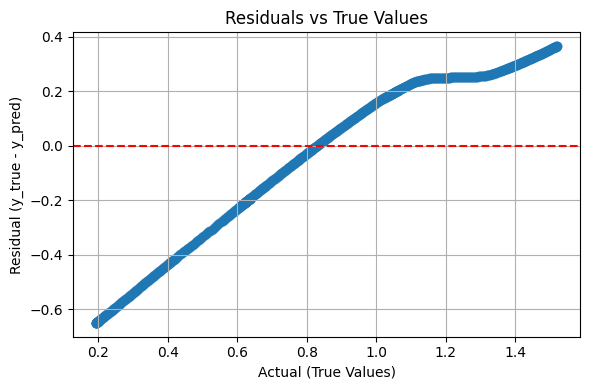

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


# ----------------------------
# 1️ Reproducibility
# ----------------------------
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"🌱 Global random seed set to {seed}")


# ----------------------------
# 2️ Model Definition
# ----------------------------
def build_model(input_dim, learning_rate=0.0005):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.2),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mape'])
    return model


# ----------------------------
# 3️ Training Function
# ----------------------------
def train_nn_regressor(train_csv, test_csv=None, target_column="target",
                       use_split=False, seed=42):
    set_global_seed(seed)

    # --- Load data ---
    df_train = pd.read_csv(train_csv)
    if test_csv:
        df_test = pd.read_csv(test_csv)
    elif use_split:
        df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=seed)
    else:
        raise ValueError("Either provide a test CSV or set use_split=True.")

    # --- Fill NaNs ---
    df_train = df_train.fillna(df_train.mean(numeric_only=True))
    df_test = df_test.fillna(df_test.mean(numeric_only=True))

    # --- Split X and y ---
    X_train = df_train.drop(columns=[target_column]).values
    y_train = df_train[target_column].values.reshape(-1, 1)
    X_test = df_test.drop(columns=[target_column]).values
    y_test = df_test[target_column].values.reshape(-1, 1)

    # --- Scale features ---
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    # --- Scale target (-1, 1) ---
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # --- Build model ---
    model = build_model(X_train.shape[1], learning_rate=0.0005)

    # --- Callbacks ---
    early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

    # --- Train ---
    history = model.fit(
        X_train, y_train_scaled,
        validation_data=(X_test, y_test_scaled),
        epochs=800,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop, reduce_lr]
    )

    # --- Predict & inverse-transform ---
    y_pred_scaled = model.predict(X_test).reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    # --- Metrics ---
    mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
    mae = mean_absolute_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)

    print(f"\n Final Test MAPE: {mape:.3f}%")
    print(f" Mean Absolute Error (MAE): {mae:.5f}")
    print(f" R² Score: {r2:.4f}")

    # --- Visualization ---
    plot_results(y_test_original, y_pred)

    return model, history, (mape, mae, r2), (y_test_original, y_pred)


# ----------------------------
# 4️ Visualization
# ----------------------------
def plot_results(y_true, y_pred):
    # --- Predicted vs Actual ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual (True Values)")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Residual Plot ---
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residuals vs True Values")
    plt.xlabel("Actual (True Values)")
    plt.ylabel("Residual (y_true - y_pred)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 5️ Example Usage
# ----------------------------
model, history, metrics, (y_true, y_pred) = train_nn_regressor(
    train_csv="../MIN_generation/Embeddings/amgOutput.csv",
    test_csv="../MIN_generation/Embeddings/generatedEmbeddings/generated_cycle_1.csv",
    target_column="relative_runtime",
    seed=42
)